Let's start!



### 1. Import TIPA libraries

In [17]:
import sys
#sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
from platform import python_version
# sys.path.insert(0,'./TIPA_library/')

from TIPA_library.main.data_preparation import *
from TIPA_library.main.thermal_image_processing import *
from TIPA_library.utils import timshow as tim
from TIPA_library.utils import rvs


#### Example Dataset
We provide example data. <br><br>
Download this dataset - <a href="https://drive.google.com/open?id=1hn3VjwILNiJ0-nNKwR80Sb6zV3Vil26w">Link</a> <br>
Unzip, move them to a directory (./data) <br>
./data/example_data.dat<br>
./data/example_data_in_front_of_building.dat<br>

In [18]:
# The matrix size has to be known in advance. e.g.320 x 240
#data = data_preparation_TIPA_protocol('./data/example_data.dat',320,240)
data = data_preparation_TIPA_protocol('./data/example_data_in_front_of_building.dat',320,240)
#print(data.time_stamp)

                                                                                                                    

### 3. Manual Inspection of the loaded thermal matrices
<br>

#### Tool 1: interactive_thermal_matrix_view <br>
simply, you can examine temperatures on your thermal image with your cursor.



<IPython.core.display.Javascript object>


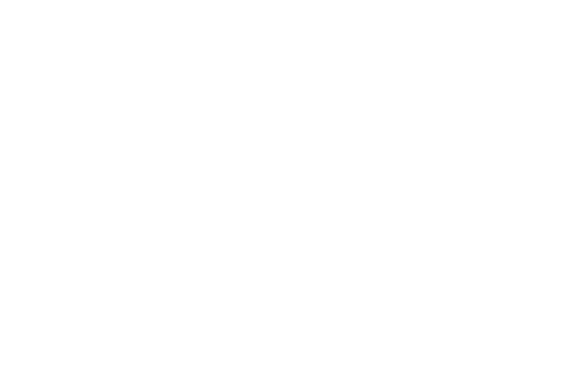

<IPython.core.display.Javascript object>


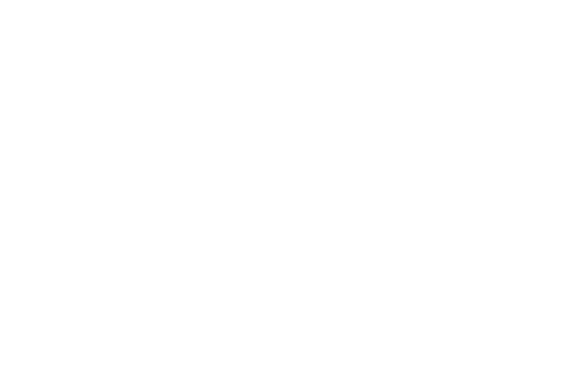

In [19]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt

%matplotlib notebook
def update(fig):
    fig.canvas.draw()
    
def interactive_thermal_matrix_view(matrix):
    fig= plt.figure()
    ax = fig.add_subplot(1,1,1)
    plt.imshow(matrix)
    
    interact(update(fig))


frame_number = 1
interactive_thermal_matrix_view(data.thermal_matrix[:,:,frame_number])


#### Tool 2: Interactive ImShow Cond1 for multiple frames <br>
simply, you can change the value on the slider (frame_num). e.g. frame number = 100


In [20]:
from ipywidgets import interactive, FloatRangeSlider, Output, VBox
%matplotlib inline

interactive_plot = interactive(data.interactive_imshow_cond,  frame_number=(0, data.thermal_matrix.shape[2]-1))
output = interactive_plot.children[-1]
output.layout.height = '320px'
interactive_plot
# VBox([range_slider,interactive_plot])

interactive(children=(IntSlider(value=1102, description='frame_number', max=2204), Output(layout=Layout(height…

#### Tool 3: Interactive ImShow Cond2 for multiple frames with a function to select your thermal range of interest <br>
in short, you can change the value on the slider (frame_num). e.g. frame number = 100 <br>
and you can adjust the thermal (temperature) range of interest <br>

In [21]:
from ipywidgets import interactive, FloatRangeSlider, Output, VBox, Layout
%matplotlib inline

# layout = Layout(width='500px')
range_slider = widgets.FloatRangeSlider(
    value=[0, +50],
    min=0., max=+60., step=0.1,
    description='thermal range of interest',
    readout_format='.1f',
#     layout=layout
)
# range_slider

interactive_plot = interactive(data.interactive_imshow_cond2,  frame_number=(0, data.thermal_matrix.shape[2]-1), thermal_range=range_slider)
output = interactive_plot.children[-1]
output.layout.height = '320px'
interactive_plot
# VBox([range_slider,interactive_plot])


interactive(children=(IntSlider(value=1102, description='frame_number', max=2204), FloatRangeSlider(value=(0.0…

#### Tool 4: Interactive ImShow Cond 3
##### for multiple frames with the optimal quantization to automatically select your thermal range of interest <br>
in short, you can change the value on the slider (frame_num). e.g. frame number = 100 <br>
and this will automatically select your thermal (temperature) range of interest <br>
We will come back here again on the preprocessing section 
###### [Key reference]<br>
Cho, Y., Julier, S.J., Marquardt, N. and Bianchi-Berthouze, N., 2017. Robust tracking of respiratory rate in high-dynamic range scenes using mobile thermal imaging. Biomedical optics express, 8(10), pp.4480-4503. https://doi.org/10.1364/BOE.8.004480

In [22]:
from ipywidgets import interactive, FloatRangeSlider, Output, VBox, Layout
%matplotlib inline


interactive_plot = interactive(data.interactive_imshow_cond3,  frame_number=(0, data.thermal_matrix.shape[2]-1))
output = interactive_plot.children[-1]
output.layout.height = '320px'
interactive_plot
# VBox([range_slider,interactive_plot])


interactive(children=(IntSlider(value=1102, description='frame_number', max=2204), Output(layout=Layout(height…

### 4. Computational Pipeline
Here, we focus on the case where an automatic ROI tracking method is used.
For the ROI selection,
a ROI can be chosen either manually or automatically. (here we select it manually)

<img src="https://github.com/deepneuroscience/TIPA/blob/master/figures/figure2.png?raw=true"> <br>
Figure 2. Computational pipeline that has been commonly applied to studies on thermal imaging-based physiological computing: this consists of three main steps, the ROI selection, automatic ROI tracking and spatial interpretation. a) with automatic ROI tracking, b) without automatic ROI tracking (in this case a head fixation mount is used)<br>
<br>
[Reference]
Youngjun Cho and Nadia Bianchi-Berthouze. 2019. Physiological and Affective Computing through Thermal Imaging: A Survey. arXiv:1908.10307 [cs], http://arxiv.org/abs/1908.10307

<br>



### 4.1. Preprocessing (Quantization)

#### [Two standard methods]
A) Non-optimal (linear) quantization <br>
Mapping temperatures to thermal images with a selected temperature range of interest, which is traditionally fixed from the first thermogram frame (e.g. 30°C to 40°C) <br>
<br>
B) Optimal quantization<br>
Mapping temperatures to thermal images adaptively against environmental temperature effects.<br>


###### [Key reference]
Cho, Y., Julier, S.J., Marquardt, N. and Bianchi-Berthouze, N., 2017. Robust tracking of respiratory rate in high-dynamic range scenes using mobile thermal imaging. Biomedical optics express, 8(10), pp.4480-4503. https://doi.org/10.1364/BOE.8.004480

<img src="https://github.com/deepneuroscience/TIPA/blob/master/figures/figure3.png?raw=true"> <br>
Figure 3. High thermal dynamic range scenes: fixed thermal range of interest is not suitable in preserving the morphological facial shape within varying ambient temperature: [top] examples of thermogram shots collected from a person walking outdoor (for 6 minutes), [bottom] temperature histograms<br>
<br>

#### 4.1.1. Non-optimal (linear) quantization

your fixed thermal range of interest is [10.000000, 40.000000]


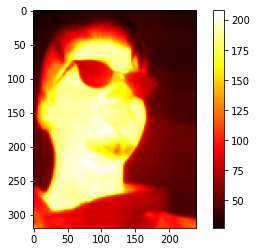

In [23]:
frame_number = 1

temp_mat = copy.deepcopy(data.thermal_matrix[:,:,frame_number])   ## Object should be deep copied. not mat = data.thermal_matrix
output = nonoptimal_quantization(temp_mat, 10, 40, True)

%matplotlib inline
tim.timshow(output)


#### 4.1.2. Optimal quantization

optimal thermal range is [24.259115, 33.570000]


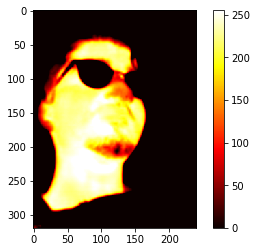

In [24]:
frame_number = 1
temp_mat = copy.deepcopy(data.thermal_matrix[:,:,frame_number])   ## Object should be deep copied. not mat = data.thermal_matrix
output = optimal_quantization(temp_mat, True)

%matplotlib inline
tim.timshow(output)

### 4.2. Automatic ROI Tracking 
#### This consists of 1) ROI selection, 2) Quantization, 3) ROI Tracking
Note: advanced trackers need to be implemented
here we are only using widely used motion tracking methods such as Median Flow, TLD etc.

In [25]:
print('1. Select your ROI and press Enter')
print('2. Press ESC to exit')
start_frame_number=1900
thermal_matrix=data.thermal_matrix[:,:,start_frame_number:-1]
ROI_seq, t_video =thermal_tracker(thermal_matrix, 'optimal', 'MEDIANFLOW', False, False)
#ROI_seq, t_video =thermal_tracker(thermal_matrix, 'optimal', 'TLD', False, False)
#ROI_seq, t_video =thermal_tracker(thermal_matrix, 'non-optimal', 'MEDIANFLOW', False, False, True, 0, 30)     
# ROI_seq, t_video =thermal_tracker(thermal_matrix) 
data.tracked_matrix=t_video

1. Select your ROI and press Enter
2. Press ESC to exit
frame: 20
frame: 40
frame: 60
frame: 80
frame: 100
frame: 120
frame: 140
frame: 160
frame: 180
frame: 200
frame: 220
frame: 240
frame: 260
frame: 280
frame: 300


In [26]:
from ipywidgets import interactive, FloatRangeSlider, Output, VBox
%matplotlib inline

interactive_plot = interactive(data.interactive_imshow_cond4,  frame_number=(0, thermal_matrix.shape[2]-1))
output = interactive_plot.children[-1]
output.layout.height = '320px'
interactive_plot
VBox([range_slider,interactive_plot])


### 4.3. Spatial Interpretation

Here, we use a classical method only - averaging. <br>

In [27]:
# print(ROI_seq)
ft_vector = np.zeros((5,thermal_matrix.shape[2]))
for i in range(thermal_matrix.shape[2]) :
    ft_vector[1,i]= np.mean(thermal_matrix[int(ROI_seq[0,i]):int(ROI_seq[0,i]+ROI_seq[2,i]) ,int(ROI_seq[1,i]):int(ROI_seq[1,i]+ROI_seq[3,i]),i])

    

##### Plot the extracted signals



In [28]:

from ipywidgets import interactive, FloatRangeSlider, Output, VBox, Layout, fixed

start_frame_number=1900

layout = Layout(width='500px')
range_slider = widgets.FloatRangeSlider(
    value=[data.time_stamp[start_frame_number],data.time_stamp[-1]],
    min=data.time_stamp[start_frame_number], max= data.time_stamp[-1], step=1,
    description='range',
    readout_format='.1f',
    layout=layout
)
# range_slider

def interactive_timeplot(time, signal, fig_w, range_bar):
    fig = plt.gcf()
    yourDPI = fig.get_dpi()

#     plt.figure(figsize=(fig_w/yourDPI,(fig_w/yourDPI)/3))
    plt.plot(time, signal)
    plt.axis([range_bar[0], range_bar[1],min(signal), max(signal)])
#     plt.axis([time[int(range_bar[0])], time[int(range_bar[1])],min(signal[int(range_bar[0]):int(range_bar[1])]), max(signal[int(range_bar[0]):int(range_bar[1])])])
#                          min(signal[range_bar[0]:range_bar[1]]), max(signal[range_bar[0]:range_bar[1]])]
#     plt.show()
    
m_interactive_timeplot = interactive(interactive_timeplot, time= fixed(data.time_stamp[start_frame_number:-1]), signal=fixed(ft_vector[1,:]), fig_w=fixed(500), range_bar=range_slider)
m_interactive_timeplot


interactive(children=(FloatRangeSlider(value=(217.418, 252.035), description='range', layout=Layout(width='500…